 # A Harsh Truth

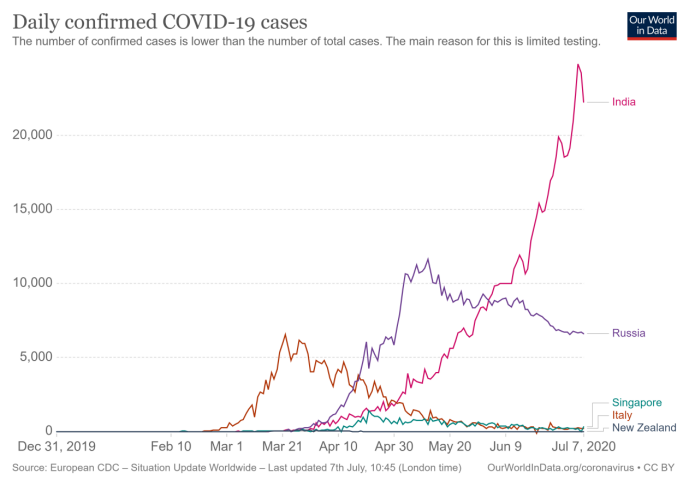

India is putting up a brave fight against the COVID, starting with its early lockdown in March and strict curfews. However, it still has not been able to flatten its daily cases like Singapore, New Zealand and Russia did despite starting their lockdown days after India did.

The objective of this notebook is to provide a state-wise breakdown of the virus’ spread to glean a few insights on how to better combat the crisis. 

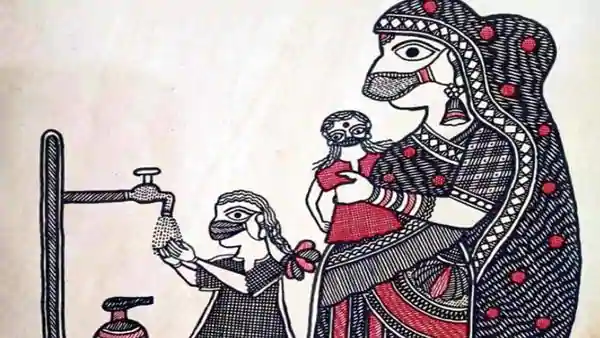
source: MINT India

# Libraries Used:

1. Numpy for linear algebra.
2. Pandas for data processing .
3. Matplotlib and Seaborn for data visualization.
4. Plotly for interactive graphs.
5. Folium for interactive leaflet map.
6. ARIMA for time-series data prediction.
7. Geopy for location coordinates to be used by folium

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from datetime import datetime, timedelta,date
import plotly.express as px

import warnings

from statsmodels.tsa.arima_model import ARIMA


warnings.filterwarnings('ignore')
%matplotlib inline 


In [ ]:
#Importing  Datasets 

df_age = pd.read_csv("../input/covid19-in-india/AgeGroupDetails.csv",index_col = 0)
df_india = pd.read_csv("../input/covid19-in-india/covid_19_india.csv",index_col= 0)
df_tests = pd.read_csv("../input/covid19-in-india/StatewiseTestingDetails.csv")
df_hosp = pd.read_csv('../input/covid19-in-india/HospitalBedsIndia.csv',index_col=0)
df_pop = pd.read_csv('../input/covid19-in-india/population_india_census2011.csv',index_col= 0)
df_labs = pd.read_csv('../input/covid19-in-india/ICMRTestingLabs.csv')

In [ ]:
#Dropping redundant data 

df_india.drop(df_india[df_india['State/UnionTerritory'] == 'Telangana***'].index,inplace = True)
df_india.drop(df_india[df_india['State/UnionTerritory'] == 'Telengana***'].index,inplace = True)
df_india.drop(df_india[df_india['State/UnionTerritory'] == 'Telengana'].index,inplace = True)

df_india.drop(df_india[df_india['State/UnionTerritory'] == 'Unassigned'].index,inplace = True)

In [ ]:
#Some preprocessing 

df_india['Date'] = pd.to_datetime(df_india['Date'],dayfirst=True)
df_india['Date'] = df_india['Date'].dt.strftime('%m/%d/%Y')

#Dropping Negative column as we already have 'TotalSamples' and 'Positive'

df_tests.drop('Negative',axis =1 ,inplace = True)
df_pop.set_index('State / Union Territory',inplace = True)



In [ ]:
#Filling in Missing Data

#For missing 'Positive' cases of COVID, the previous known value is filled in.
df_tests['Positive'].fillna(method='ffill',inplace = True)

#For missing 'Sub-District Hospitals' values, assumed 0 hospitals are present in state.
df_hosp.fillna(0,inplace = True)



# State Report Overlook

In [ ]:
#making a database of cases of every state for the last day of reporting 

state_report = df_india.groupby(by = 'State/UnionTerritory').max().reset_index()

state_report['Active'] = (state_report['Confirmed'] - (state_report['Cured'] + state_report['Deaths']))
state_report['Deaths per 100 Cases'] = round(((state_report['Deaths']/state_report['Confirmed'])*100),2)

state_report.drop(columns = ['Time' , 'ConfirmedIndianNational' , 'ConfirmedForeignNational'],inplace = True)

state_report.style.background_gradient(cmap = 'Greens',subset= ['Cured'])\
                    .background_gradient(cmap = 'Reds',subset= ['Deaths'])\
                    .background_gradient(cmap = 'Blues',subset= ['Confirmed'])\
                    .background_gradient(cmap = 'Greys',subset= ['Active'])\
                    .background_gradient(cmap = 'Reds',subset =
                                         ['Deaths per 100 Cases']).format('{:.2f}', subset = ['Deaths per 100 Cases'])


At first glance, the main virus hotspots seem to be the most populous states of the country. But it does not follow that general trend, with Delhi having the 3rd highest confirmed cases but a comparatively lower population. Let's do some analysis. 

# Map Visualization

In [ ]:

#State latitudes and longitudes found using geopy

Location_dict = {'Andaman and Nicobar Islands': (10.2188344, 92.5771329),
 'Andhra Pradesh': (15.9240905, 80.1863809),
 'Arunachal Pradesh': (27.6891712, 96.4597226),
 'Assam': (26.4073841, 93.2551303),
 'Bihar': (25.6440845, 85.906508),
 'Chandigarh': (30.7334421, 76.7797143),
 'Chhattisgarh': (21.6637359, 81.8406351),
 'Daman & Diu': (20.42000485, 72.86376290300566),
 'Delhi': (28.6517178, 77.2219388),
 'Goa': (15.3004543, 74.0855134),
 'Gujarat': (22.41540825, 72.03149703699282),
 'Haryana': (29.0, 76.0),
 'Himachal Pradesh': (31.81676015, 77.34932051968858),
 'Jammu and Kashmir': (33.5574473, 75.06152),
 'Jharkhand': (23.4559809, 85.2557301),
 'Karnataka': (14.5203896, 75.7223521),
 'Kerala': (10.3528744, 76.5120396),
 'Ladakh': (33.9456407, 77.6568576),
 'Madhya Pradesh': (23.9699282, 79.39486954625225),
 'Maharashtra': (19.531932, 76.0554568),
 'Manipur': (24.7208818, 93.9229386),
 'Meghalaya': (25.5379432, 91.2999102),
 'Mizoram': (23.2146169, 92.8687612),
 'Nagaland': (26.1630556, 94.5884911),
 'Odisha': (20.5431241, 84.6897321),
 'Puducherry': (11.9340568, 79.8306447),
 'Punjab': (30.9293211, 75.5004841),
 'Rajasthan': (26.8105777, 73.7684549),
 'Sikkim': (27.601029, 88.45413638680145),
 'Tamil Nadu': (10.9094334, 78.3665347),
 'Telangana': (17.8495919, 79.1151663),
 'Telengana': (17.329125, 78.5822228),
 'Tripura': (23.7750823, 91.7025091),
 'Uttar Pradesh': (27.1303344, 80.859666),
 'Uttarakhand': (30.091993549999998, 79.32176659343018),
 'West Bengal': (22.9964948, 87.6855882)}

In [ ]:
map_states = state_report.drop(index=[5,8,9,36],errors = 'ignore')
map_states.reset_index(inplace = True,drop = True)

india_map = folium.Map(location=[21, 78], zoom_start=5, tiles = 'cartodbpositron',min_zoom = 5, max_zoom = 7,control_scale=True)


for i in range(0,len(map_states)):
    state = map_states['State/UnionTerritory'][i]
    cases = map_states['Confirmed'][i]  
    deaths = map_states['Deaths'][i]
    cured = map_states['Cured'][i]
    
    location = Location_dict[state]
    
    folium.Circle([location[0],location[1]],radius = float(cases * 0.8),color = '#10B4AB',fill_color = 'cyan',
                  fill = True, 
                  tooltip = "<h5 style = 'text-align:center;font-weight:bold'>"+state+"</h5>"\
                  + "<div style = 'text-align:center;'>" + "<b>"+'Confirmed : '+"</b>"+ str(cases)+"</div>"\
                  + "<div style = 'text-align:center;'>" + "<b>"+'Recovered : '+"</b>"+ str(cured)+"</div>"\
                  + "<div style = 'text-align:center;'>" + "<b>"+'Deaths : '+"</b>"+ str(deaths)+"</div>").add_to(india_map)
    
india_map.save('indiamap.html')
india_map

We can deduce that the worst-struck states of India are the ones with densely packed urban areas, like Mumbai in Maharashtra, Chennai in Tamil Nadu and New Delhi. Let's see how the total national confirmed cases are distributed.

# Data Analysis

In [ ]:
state_report['per cent Confirmed'] = (state_report['Confirmed']*100/state_report.sum()['Confirmed'])
pie = state_report.drop(index = state_report.index[state_report['State/UnionTerritory'] == 'Cases being reassigned to states'])

plt.figure(figsize = (20,20))

fig1 = px.pie(data_frame=pie,values = 'Confirmed',
        hover_name='State/UnionTerritory',
        labels = {'State/UnionTerritory':'State ','Confirmed':'Confirmed Cases '},
        hole = 0.65, color = 'Confirmed',
        template = 'ggplot2',
        color_discrete_sequence=  px.colors.sequential.Mint_r,
        title = "State-wise Distribution of Confirmed Covid Cases (as of "+ str(state_report['Date'].max())+")")
        

fig1.update_traces(textposition='inside', textinfo='percent')

#X------------------------------------------------------------------------------------------------------------------------------------------------X

temp = state_report.sort_values(by = 'Confirmed',ascending= False)[0:20]
temp.reset_index(inplace = True,drop = True)

temp.sort_values(by = 'Confirmed',ascending = False)

plt.figure(figsize= (20,15))
fig2 = px.bar(data_frame=temp, x = temp['State/UnionTerritory'], y=temp['Confirmed'],
            color_continuous_scale= px.colors.sequential.Mint, color = 'Confirmed',
            text='Confirmed',template = 'plotly_white',
            labels = {'State/UnionTerritory':'State','Confirmed':'Confirmed Cases '},
            hover_name = 'State/UnionTerritory',
            hover_data = {'Confirmed':True,'State/UnionTerritory':False}, )

fig2.update_layout(title = {
    'text' : 'Top 20 States by Confirmed Cases',
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title = '')

fig2.update_traces(texttemplate = '%{text:.2s}',textposition = 'outside',textfont_size =13)

fig1.show()
fig2.show()

In [ ]:
temp = state_report.sort_values(by = 'Confirmed',ascending= False)[0:20]
temp.reset_index(inplace = True,drop = True)

temp['Percentage'] =round((temp['Cured']/temp['Confirmed'])*100,2)
plt.figure(figsize = (12,8),dpi = 150)

fig1 = px.bar(data_frame=temp, x = temp['State/UnionTerritory'], y=temp['Confirmed'],
            color_continuous_scale= px.colors.sequential.Blues, color = temp['Percentage'],
            text= temp['Percentage'],template = 'ggplot2',
            labels = {'State/UnionTerritory':'State','Confirmed':'Confirmed Cases ','Percentage':'Percentage Cured '},
            hover_data = {'Confirmed':True,'Percentage':True,'State/UnionTerritory':False}, 
            hover_name = 'State/UnionTerritory')

fig1.update_traces(textposition = 'outside',texttemplate = '%{text:.3s}',textfont_size =13)
fig1.update_layout(title = {
    'text':' Percentage of Cured to Confirmed Cases',
    'x':0.5,
})
fig1.show()

Delhi has done extremely well with curing 90% of its cases. Maharashtra and Tamil Nadu have also done well considering their enormous volume of cases.

It's alarming to see that those 3 states contribute almost **60%** of the entire country's cases. 

Gujarat,Uttar Pradesh and Telangana also have an average of 30,000 cases. Let's see how these patients have recovered.

In [ ]:
state_deaths = state_report.sort_values(by="Deaths",ascending = False)[0:20]

plt.figure(figsize = (12,8),dpi = 150)

fig1 = px.bar(x = state_deaths['State/UnionTerritory'],y = state_deaths['Deaths'],orientation='v',
       labels = {'x':'Deaths','y':'State or Union Territory','State/UnionTerritory':'State','Deaths per 100 Cases':'Deaths per 100 Cases '},
       color = state_deaths['Deaths per 100 Cases'], color_continuous_scale = px.colors.sequential.Reds,
       hover_name = 'State/UnionTerritory', hover_data = {'Deaths':True,'Deaths per 100 Cases':True,'State/UnionTerritory':False}, 
       data_frame = state_deaths,template = 'ggplot2', text = state_deaths['Deaths per 100 Cases'],
       title = "India's Deadliest States with Deaths per 100 Cases")

fig1.update_layout(title = {'x':0.5})
fig1.update_traces(textposition = 'outside')
fig1.show()

Gujarat comes in as the deadliest state with 5 people dead for every 100 infected, followed by Maharashtra, Madhya Pradesh and West Bengal. Tamil Nadu has quite a low ratio considering its large number of infected. Could it be because it has better medical facilities?

In [ ]:
#Converting dtype of columns in df_hosp to integer

def changetoint(column):
    for i,v in enumerate(column):
        n = ''
        n = n.join([x for x in v if x.isdigit()])
        
        return int(n)

df_hosp['NumPrimaryHealthCenters_HMIS'] = df_hosp['NumPrimaryHealthCenters_HMIS'].apply(changetoint)

df_hosp.drop(index = df_hosp.index[df_hosp['State/UT'] == 'All India'],inplace = True)

In [ ]:
#Taking a look at lab data.
sunburst_data = df_labs[['type','state']]
px.sunburst(sunburst_data,path = ['type','state'],color = 'type',
            
           color_discrete_sequence = px.colors.qualitative.Pastel2,height = 750,width = 750,template = 'ggplot2',title='Available Research Facilities in State based on Lab Type')

In [ ]:
# looking at the state medical facilities

top_community_hosp = df_hosp.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_primary_hosp = df_hosp.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_rural_hosp = df_hosp.nlargest(10,'NumRuralHospitals_NHP18')
total_hosp =  df_hosp.nlargest(10,'TotalPublicHealthFacilities_HMIS')

plt.figure(figsize = (20,10),dpi = 200)
plt.style.use(u'ggplot')

plt.subplot(2,2,1)

sns.barplot(y = top_community_hosp['State/UT'], x = top_community_hosp['NumCommunityHealthCenters_HMIS'],data= df_hosp,
            orient = 'h' , color = '#58A25D')
plt.xlabel('')
plt.ylabel("")
plt.title('Number of Community Health Centres',fontsize = 17)
plt.tick_params(labelsize = 13)


plt.subplot(2,2,2)

sns.barplot(y = top_rural_hosp['State/UT'], x = top_rural_hosp['NumRuralHospitals_NHP18'],data= df_hosp,
            orient = 'h' , color = '#8ABC7C')
plt.xlabel('')
plt.ylabel("")
plt.title('Number of Rural Health Facilities',fontsize = 17)
plt.tick_params(labelsize = 13)


plt.subplot(2,2,3)

sns.barplot(y = top_primary_hosp['State/UT'], x = top_primary_hosp['NumPrimaryHealthCenters_HMIS'],data= df_hosp,
            orient = 'h' , color = '#00AAAA')
plt.xlabel('')
plt.ylabel("")
plt.title('Number of Primary Health Centres',fontsize = 17)
plt.tick_params(labelsize = 13)


plt.subplot(2,2,4)

sns.barplot(y = total_hosp['State/UT'], x = total_hosp['TotalPublicHealthFacilities_HMIS'],data= df_hosp,
            orient = 'h' , color = '#008B8B')

plt.xlabel('')
plt.ylabel("")
plt.title('Total Public Health Facilities',fontsize = 17)
plt.tick_params(labelsize = 13)

plt.suptitle('State-wise Distribution of Health Facilites',fontsize = 25,x = 0.65)
plt.tight_layout(rect=[0, 0.05, 1.2, 0.95])


Tamil Nadu doesn't rank that high when comparing Total Public Health Facilities. Its low mortality rate can be attributed to faster detection of the virus in patients. Despite having a lot of Public and Rural health facilities, Karnataka is still contending to cure patients.

In [ ]:

latest_tests = df_tests.groupby('State').max().sort_values('TotalSamples',ascending = False)[0:20]
latest_tests['Ratio'] = round((latest_tests['Positive']/latest_tests['TotalSamples'])*1000,2)

fig = px.bar(data_frame = latest_tests,
             y  = latest_tests['TotalSamples'],x =  latest_tests['TotalSamples'].index,template = 'ggplot2',text = latest_tests['Ratio'],
             color = latest_tests['Ratio'],color_continuous_scale= px.colors.sequential.Redor,
             labels = {'TotalSamples':'Number of COVID Tests Done',"Ratio":'Positive Cases for every 1000 tests'},
             hover_name = latest_tests['TotalSamples'].index
             )

fig.update_layout(title = {
    'text': 'COVID Tests Done vs Positive Cases for Every 1000 tests'
})
fig.update_traces(textposition = 'outside',textfont_size = 13)

Maharashtra,Delhi,Telangana need to increase their testing as >10% of their tests are positive. Our prime weapon against COVID is detection, contact tracing and breaking the chain. 

Andhra Pradesh has done well to have a high test rate despite a limited count of health care institutions in state.

# Time-Series Breakdown

In [ ]:


df_india['Date'] = pd.to_datetime(df_india['Date'])
recent_dates = df_india[df_india["Date"] > pd.to_datetime('03/10/20')]

current_date = str(recent_dates['Date'].max())
recent_dates['Date'] = recent_dates['Date'].dt.strftime('%Y-%m-%d')

fig = px.bar(recent_dates,x ='State/UnionTerritory',y = 'Confirmed',animation_frame = 'Date',
             template = 'ggplot2',title = 'Confirmed Cases',
             color = 'Confirmed',labels = {'State/UnionTerritory':''})

fig.update_layout(xaxis={'categoryorder':'total descending'})

In [ ]:
df_india['Date'] = pd.to_datetime(df_india['Date'])

latest = df_india[df_india["Date"] > pd.to_datetime('2020-04-01')]

latest2 = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured',"Date"].max().reset_index()

latest2['Active'] = latest2['Confirmed'] - (latest2['Deaths'] - latest2['Cured'])

state_list = list(latest2.sort_values('Active',ascending = False)['State/UnionTerritory'])[0:15]

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}



In [ ]:
fig = plt.figure(figsize=(25,20),dpi = 250)

import matplotlib.dates as mdates

def movingaverage(values,N):
    cumulativesum = [0]
    movingav = []
    
    for i,x in enumerate(values,1):
        cumulativesum.append(cumulativesum[i-1] + x)
        
        if i >= N:
            movingav.append((cumulativesum[i] - cumulativesum[i-N]) / N)
        else:
            movingav.append(0)
    return movingav


def movingaverage2(values,N):
    cumulativesum = [0]
    movingav = []
    
    for i,x in enumerate(values,0):
        
        if i >= N:
            movingav.append((values[i] - values[i-N]) / N)
        else:
            movingav.append(0)
    return movingav


def percentchange(values):
    
    pctchange = []
    
    for i in range(0,len(values)):
        pastsum = 0
        
        for j in range(i):
            pastsum = pastsum + values[j]
        
        pctchange.append(int((values[i]/pastsum)*100))
        
    return pctchange

axno = 1
sns.set_style('darkgrid')

for state in state_list:
    df1 = latest[latest['State/UnionTerritory'] == state].reset_index(drop = True)

    new_cases = [0]

    state_dates = latest[latest['State/UnionTerritory'] == state]['Date']
    
    for i in range (1,len(df1)):
        cases_delta = (df1['Confirmed'][i] - df1['Confirmed'][i-1])
        new_cases.append(cases_delta)

    df1['New Cases'] = new_cases
    
    
    ax = fig.add_subplot(5,3,axno)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    
    ax.bar(state_dates.values,df1['New Cases'], label = 'Day wise confirmed cases',color = 'darkcyan')
    plt.title(state,fontsize = 20)
    
    moving_aves = movingaverage(df1['New Cases'],10)
    
    moving_aves2 = movingaverage2(df1['Confirmed'],10)
    
    ax.plot(state_dates.values,moving_aves2,color='red',lw = 2.5,label = 'Moving Average')
    plt.xlim(date(2020,4, 1),df1['Date'].max())
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left',)
    axno = axno + 1

plt.suptitle('Confirmed Cases with a 10 day moving average',fontsize = 30,y=1.0)
plt.tight_layout(pad = 4.0)
plt.savefig("State")

This graphs out the daily cases from April 1 to today's date. It's noticeable that many states have a very steep growth of cases.

Some insights can be gained by analysing the state that responded the best to the crisis - Kerala. It would be beneficial to see the cases trend and what Kerala's government has done to curb the spread of the virus in its state.


In [ ]:
df1 = latest[latest['State/UnionTerritory'] == 'Kerala'].reset_index(drop = True)
fig = plt.figure(figsize=(10,3),dpi = 100)

new_cases = [0]

state_dates = latest[latest['State/UnionTerritory'] == 'Kerala']['Date']
    
for i in range (1,len(df1)):
    cases_delta = (df1['Confirmed'][i] - df1['Confirmed'][i-1])
    new_cases.append(cases_delta)

df1['New Cases'] = new_cases

ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    
ax.bar(state_dates.values,df1['New Cases'], label = 'Day wise confirmed cases',color = 'darkcyan')

plt.title('Kerala',fontsize = 20)

moving_aves = movingaverage(df1['New Cases'],10)

ax.plot(state_dates.values,moving_aves,color='red',lw = 2.5,label = 'Moving Average')

ax.text(date(2020,5, 14), 28, "*",fontsize = 20)
ax.text(date(2020,5,17), 31, "*",fontsize = 20)
ax.text(date(2020,6, 5), 120, "*",fontsize = 20)



handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper left',)

Kerala was well equipped to deal with the pandemic having dealt with the NIPAH outbreak in 2019. The state government declared a state of medical emergency,very early, on 30 January 2020. 

Early Preparation was key. Because of the available infrastructure and readiness of the medical facilities to deal with a crisis of this scale, it has managed to keep its daily infections at a fraction of its neighboring states'.

Comparing with neighboring states,however, Kerala has done only 275823 tests (7/8/2020) which is quite low.

 **Timeline of Government actions in the last 4 months:**

1* Revised testing begins for medical staff,expatriat travellers and Migrant workers. (Sentinel Surveillance act - 14/5/2020)

2* Start of the Break The Chain hygiene awareness movement.(17/05/2020)

3* 100,000 tests done.(05/06/2020)

# Predicting State-wise Confirmed Cases Using ARIMA

In [ ]:
#prediction using ARIMA 
from datetime import datetime,timedelta
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(25,20),dpi = 250)
subplotno = 1

for state in state_list:
    
     
    state_df = latest[latest['State/UnionTerritory'] == state]
    y = state_df['Confirmed']
    
    arima = ARIMA(y, order=(5, 1, 0))
    arima = arima.fit(trend='c', full_output=True, disp=True)
    forecast = arima.forecast(steps= 33)
    pred = list(forecast[0])

    start_date = state_df['Date'].max()

    prediction_dates = [pd.to_datetime(start_date)]

    for i in range(32):
        
        tempdate = start_date + timedelta(days=1)
        prediction_dates.append(tempdate)
        start_date = tempdate
    
    ax = fig.add_subplot(5,3,subplotno)
    
    plt.title(state + ' : ' + str(int(round(pred[-1],0))) + ' Cases' , fontsize = 16)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(fontsize = 8)
    
    sns.lineplot(y= pred,x= prediction_dates,linestyle ='dashed',label = 'Predicted',color = 'red')
    sns.lineplot(y=state_df['Confirmed'] , x = state_df['Date'] ,color = 'darkcyan',label = 'Actual')
    plt.legend()
    

    plt.ylabel('')
    plt.xlabel('')

    subplotno +=1

plt.suptitle('State-wise Predicted Number of Cases by '+str(prediction_dates[-1].date()) ,fontsize = 23)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Statepred - ARIMA')

It's frightening to see what may come to be. But with many states reinstating lockdown and stricter policing of curfew ,it is quite possible to flatten the curve in the next few months.  

Remember to stay in and stay safe. Our fight with COVID starts and ends with the people. Please do your part, wear a mask and help those around you however you can.


I hope this notebook was informative. 
If you liked this notebook, do upvote. Any comments are welcome. 